In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from time_series_experiments import utils
from time_series_experiments import baseline
from time_series_experiments import transformer

tf.get_logger().setLevel('ERROR')

In [3]:
seed = 0xC0FFEE
fdw = 240
fw = 120

sunspot_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

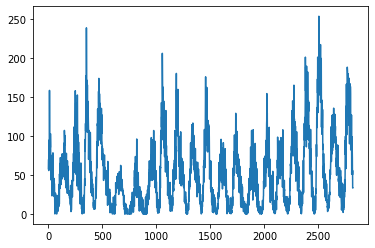

In [4]:
plt.plot(np.arange(sunspot_df.shape[0]), sunspot_df['Sunspots'].values)

In [5]:
y = sunspot_df['Sunspots'].values

x_train_idx, y_train_idx, x_test_idx, y_test_idx = utils.train_test_split_index(
    y.shape[0], fdw, fw, test_size=0.1, random_seed=seed
)

x_train = np.expand_dims(y[x_train_idx], axis=-1)
y_train = y[y_train_idx]
x_test = np.expand_dims(y[x_test_idx], axis=-1)
y_test = y[y_test_idx]

In [6]:
x_train.shape

(2215, 240, 1)

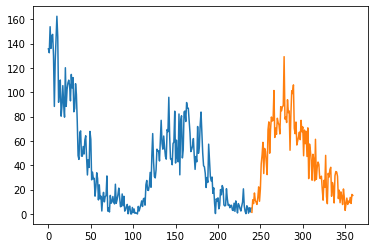

In [7]:
xplot = np.arange(fdw + fw)
plt.plot(xplot[:fdw], x_train[100])
plt.plot(xplot[-fw:], y_train[100])

In [8]:
baseline_model = baseline.LatestNaiveBaseline(fw=fw)
y_pred_baseline = baseline_model.predict(x_test)
print('RMSE', utils.rmse(y_test, y_pred_baseline))

RMSE 80.60568295722082


In [9]:
scaler = utils.ScalerWrapper(StandardScaler(), log_transform=False)
scaler.fit(x_train)

xtr = scaler.transform(x_train)
ytr = scaler.transform(y_train)

transformer_model = transformer.Transformer(
    num_layers=1,
    attention_dim=32,
    num_heads=4,
    hidden_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    attention_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    pwffn_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    output_kernel_initializer=utils.get_initializer("glorot_uniform", seed),
    layer_norm_epsilon=None,
    epochs=200,
    batch_size=32,
    optimizer=keras.optimizers.RMSprop(0.009),
    loss=keras.losses.MeanAbsoluteError(),
)
history = transformer_model.fit(xtr, ytr, verbose=1)

Train on 2215 samples
Epoch 1/200
2215/2215 [==============================] - 20s 9ms/sample - loss: 1.3316
Epoch 2/200
2215/2215 [==============================] - 19s 9ms/sample - loss: 0.2879
Epoch 3/200
2215/2215 [==============================] - 19s 9ms/sample - loss: 0.2802
Epoch 4/200
2215/2215 [==============================] - 19s 9ms/sample - loss: 0.2805
Epoch 5/200
2215/2215 [==============================] - 20s 9ms/sample - loss: 0.2764
Epoch 6/200
2215/2215 [==============================] - 20s 9ms/sample - loss: 0.2729
Epoch 7/200
2215/2215 [==============================] - 20s 9ms/sample - loss: 0.2700
Epoch 8/200
2215/2215 [==============================] - 20s 9ms/sample - loss: 0.2708
Epoch 9/200
2215/2215 [==============================] - 19s 9ms/sample - loss: 0.2689
Epoch 10/200
2215/2215 [==============================] - 19s 9ms/sample - loss: 0.2667
Epoch 11/200
2215/2215 [==============================] - 19s 9ms/sample - loss: 0.2652
Epoch 12/200
2215/2

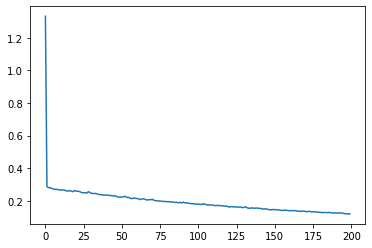

In [10]:
plot_y = np.array(history.history['loss'])
plot_x = np.arange(plot_y.shape[0])
plt.plot(plot_x, plot_y)

In [11]:
xt = scaler.transform(x_test)

y_pred, weights = transformer_model.predict(xt)
y_pred = scaler.inverse_transform(y_pred)

print('RMSE', utils.rmse(y_test, y_pred)) 
print('MASE', utils.mase(y_test, y_pred, y_pred_baseline))

RMSE 53.49537299275078
MASE 0.5966732658362598


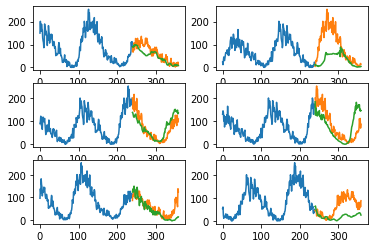

In [12]:
fig, axes = plt.subplots(3, 2)
axes = [item for sublist in axes for item in sublist]

indexes = np.random.choice(np.arange(y_pred.shape[0]), len(axes))

for i, ax in zip(indexes, axes): 
    plot_x = np.squeeze(x_test[i])
    plot_y_pred = np.squeeze(y_pred[i])
    plot_y = np.squeeze(y_test[i])
    
    plot_x_numbers = np.arange(0, plot_x.shape[0])
    plot_y_numbers = np.arange(plot_x.shape[0], plot_x.shape[0] + plot_y.shape[0])

    ax.plot(plot_x_numbers, plot_x)
    ax.plot(plot_y_numbers, plot_y)
    ax.plot(plot_y_numbers, plot_y_pred)

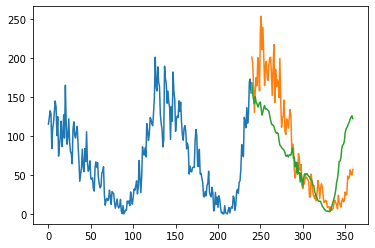

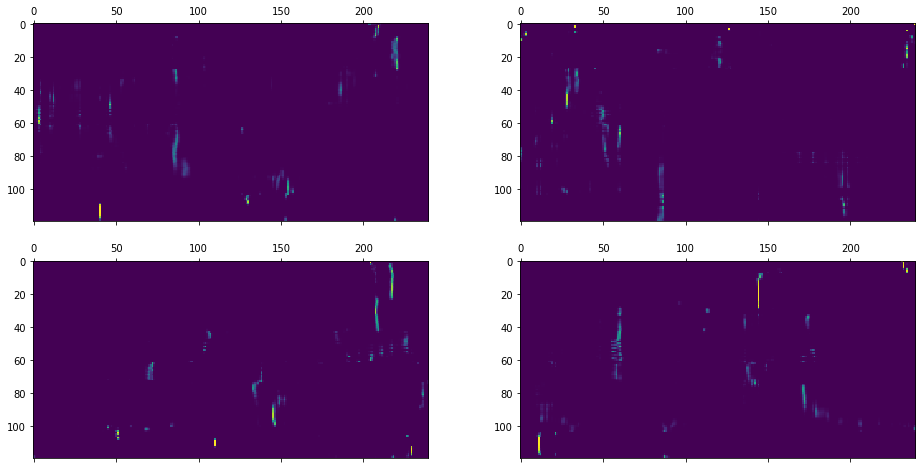

In [15]:
def plot_weights(attention, x, y):     
    fig = plt.figure(figsize=(16, 8))
    
    for i in range(attention.shape[0]):
        ax = fig.add_subplot(2, 2, i+1)
        head_attn = attention[i]
        ax.matshow(head_attn, cmap='viridis')
        
#         ax.set_xticks(range(len(x)))
#         ax.set_yticks(range(len(y)))
        
random = np.random.randint(y_pred.shape[0])

plot_x = np.arange(x_test[random].shape[0] + y_pred[random].shape[0])
plt.plot(plot_x[0:x_test[random].shape[0]], x_test[random])
plt.plot(plot_x[-y_pred[random].shape[0]:], y_test[random])
plt.plot(plot_x[-y_pred[random].shape[0]:], y_pred[random])

plot_weights(weights['decoder_encoder_attention'][0][random], x_test[random], y_pred[random])